# Beer draft modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm_notebook
import random as random

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from my_classes import Dropper, Dummier, Vectorizer, Stemmer, Series_Vectorizer

In [32]:
helles_df = pd.read_csv("./data/reviews/helles_cleaned.csv")

In [33]:
helles_df.shape

(2853, 10)

In [34]:
helles_df.head()

,rating,look,smell,taste,feel,overall,review,date,id,name
0,4.40,4.25,4.25,4.50,4.25,4.50,Clear bright straw with a nice foamy white hea...,2019-09-07,712,Weihenstephaner Original
1,4.31,5.00,4.00,4.50,4.00,4.25,One of the better helles style beers imported ...,2019-07-30,712,Weihenstephaner Original
2,4.41,4.50,3.50,5.00,4.00,4.50,Look is pale gold with dense white head with a...,2019-07-02,712,Weihenstephaner Original
3,3.93,3.75,3.75,4.00,4.00,4.00,One fingers white head with decent lacing and ...,2019-06-28,712,Weihenstephaner Original
4,4.23,4.25,4.25,4.25,4.00,4.25,11.2-oz. bottle needed a strong pour into a 16...,2019-06-25,712,Weihenstephaner Original


In [38]:
helles_df.describe()

,rating,look,smell,taste,feel,overall,id,rating_bin
count,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000
mean,3.665917,3.724984,3.557704,3.678892,3.716222,3.719464,80539.022433,0.515247
std,0.538898,0.563400,0.583719,0.612842,0.592788,0.588903,98444.641351,0.499855
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,280.000000,0.000000
25%,3.400000,3.500000,3.250000,3.500000,3.500000,3.500000,9603.000000,0.000000
50%,3.730000,3.750000,3.500000,3.750000,3.750000,3.750000,43881.000000,1.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,104355.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,425373.000000,1.000000


In [39]:
#setting my binary rating at about the median
helles_df["rating_bin"] = helles_df["rating"].apply(lambda x: 1 if x > 3.7 else 0)

### Baseline

In [40]:
#checking baseline accuracy
baseline = helles_df["rating_bin"].value_counts(normalize=True).max()
baseline

0.5152471083070452

### Logistic

In [41]:
#setting X and y, and creating split
X=helles_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs")

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.721
CV std = 0.005

Test score: 0.737


In [42]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(15)

,feature,coeff
3725,great,2.703873
2990,excellent,2.561536
5528,nice,2.317493
2325,delicious,2.220485
1217,bread,1.852391
3318,floral,1.517091
2628,doughy,1.516556
1225,bready,1.476763
3966,helles,1.376475
7505,solid,1.364336


In [43]:
for i in range(0,helles_df["review"].str.contains("crackery").sum()):
    print(helles_df[helles_df["review"].str.contains("crackery")].iloc[i,0])
    print(helles_df[helles_df["review"].str.contains("crackery")].iloc[i,6])
    print("")

4.27
A nice, thick head leads into a golden pint. Taste is hoppy on the front, leading into a grassy and earthy finish with a slight crackery taste. Not bad!

3.96
another german classic here on tap at prost, what an awesome spot to get acquainted and reacquainted with the all timers. this is a very german lager here, bright yellow in color, well clear, and with slowly rising carbonation lazily joining the tall airy white head that never really settles, so cool to have this on tap! its a true to style german lager of course, but with maybe a little more sweetness to it than some, an almost yellow corn note in the center from the grain, and really its necessary, the beer would be so light without that element, this just sort of beefs it up enough, but i find myself pulling it down in huge gulps anyway, this beer is just made for that kind of fast paced volume swilling. a light classic german hop profile in the taste but it sets in a little earlier than i am used to, which i think also h

Poured into a snifter. 3.75 A: Moderately hazed dark yellow color. Two fingers of frothy off-white head. Retention is about average and one finger of lacing is left behind. 3.75 S: Surprisingly citrusy with lemon and lime notes. Grassy hay, crackery malts, atale pumpernickel bread.  3.5 T: Grassy maltiness. The taste is more lemony, whereas the nose was more limey. Malts are crackery, bready, and grainy in that order. Hay, earth, just a touch of mineral, and quinoa. 4.0 M: Medium body. Good moderate carbonation. Refreshing and light on the tongue with an almost spritziness and at the same time pleasantly creamy. Very nice here. 3.75 D: Well crafted beer that is perfect for a hot day and tasty enough to warrant a repeat (or several).

4.25
Aroma: Slightly sweet crackery Pilsner malt base up front. Light earthy hop bitterness. Relatively clean lager character. 

Appearance: Nearly clear golden pour with a low white head that retains well. Appears still in the glass. 

Flavor: More cracke

500ml can - this is another one of those stupidly difficult to determine where they originate from German brews, in the vein of the last few years' worth of Costco Advent calendars, ja? This beer pours a clear, pale golden yellow colour, with a teeming tower of puffy, finely foamy, and somewhat bubbly bone-white head, which leaves some stringy archipelago lace around the glass as it quickly settles. It smells of bready pale cereal malt, a bit of earthy clover honey, subtle untethered yeasty notes, and some decent leafy, weedy, and grassy noble hop bitters. The taste is more crackery and grainy pale malt, further 'healthy' breakfast cereal essences, some genial apple and pear fruitiness, a sense of retreating yeastiness, and more easy-going (what's the German phrase for je ne sais quoi?) leafy, grassy, and floral green hoppiness. The bubbles are pretty tame in their barely supportive frothiness, the body a solid medium weight for the style, and mostly smooth, nothing really here willing

Tallboy can from the LCBO; dated Dec 1 2016 and served well-chilled. Pours a crystal-clear golden colour, with one finger of loose, frothy white head situated atop. It fizzles itself away over the next minute or two, with only a modest collar of foam surviving afterwards - save for a few patches of bubbly islands, the surface is otherwise bare. Minimal lacing; it's a pretty typical-looking pale lager. Lots of grainy, bready pale barley malts on the nose, with notes of soda crackers, grassy hay and herbal, somewhat spicy continental hops. A well-crafted beer with a straightforward flavour profile (which is as a helles lager should be). Pale barley malts basically run the show here, with a crackery cereal grain flavour alongside some bready sweetness at the forefront. Noble hops join in on the back end, where they supply a subdued bitterness - grassy and lightly earthy, with floral and herbal suggestions. Finishes clean - or at least clean-ish, as the hops do linger for a few moments. Li

### Stemming Logistic

In [44]:
#setting X and y, and creating split
X=helles_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs")

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             ("stem", stem),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.733
CV std = 0.014

Test score: 0.729


In [45]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[2][1].feature_names, log_pipe.steps[3][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(15)

,feature,coeff
3487,great,2.620317
5156,nice,2.414409
2796,excel,2.350471
1194,breadi,1.886410
1191,bread,1.812290
799,balanc,1.579341
7606,thi,1.560483
3711,hell,1.493684
2198,delicious,1.433923
4593,love,1.422819


### Finding best C for logistic

In [46]:
#setting X and y, and creating split
X=helles_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegressionCV(solver = "lbfgs", Cs=20, cv=5, max_iter=250, verbose=10, n_jobs=3)

#Setting up pipeline
logcv_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
logcv_pipe.fit(X_train, y_train)

print("Train score: {0:.3f}".format(logcv_pipe.score(X_train, y_train)))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  3.8min remaining:  2.5min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  5.8min finished


Train score: 0.862


In [47]:
logcv_pipe.steps[2][1].C_[0]

0.615848211066026

In [48]:
#setting X and y, and creating split
X=helles_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026, max_iter=250)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.723
CV std = 0.007

Test score: 0.741


In [49]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(15)

,feature,coeff
3725,great,2.157669
5528,nice,1.953175
2990,excellent,1.853523
2325,delicious,1.638430
1217,bread,1.500946
3318,floral,1.265917
1225,bready,1.233518
3966,helles,1.184655
2628,doughy,1.148722
3448,fresh,1.028798


In [51]:
lr_predict = log_pipe.predict(X_test)

print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       265
           1       0.77      0.74      0.75       306

   micro avg       0.74      0.74      0.74       571
   macro avg       0.74      0.74      0.74       571
weighted avg       0.74      0.74      0.74       571



In [52]:
conmat = confusion_matrix(y_test, lr_predict, labels = [1,0])

pd.DataFrame(conmat,
            columns = ["p_high", "p_low"],
            index = ["high", "low"])

,p_high,p_low
high,227,79
low,69,196


In [55]:
lr_prob = [y for x,y in log_pipe.predict_proba(X_test)]

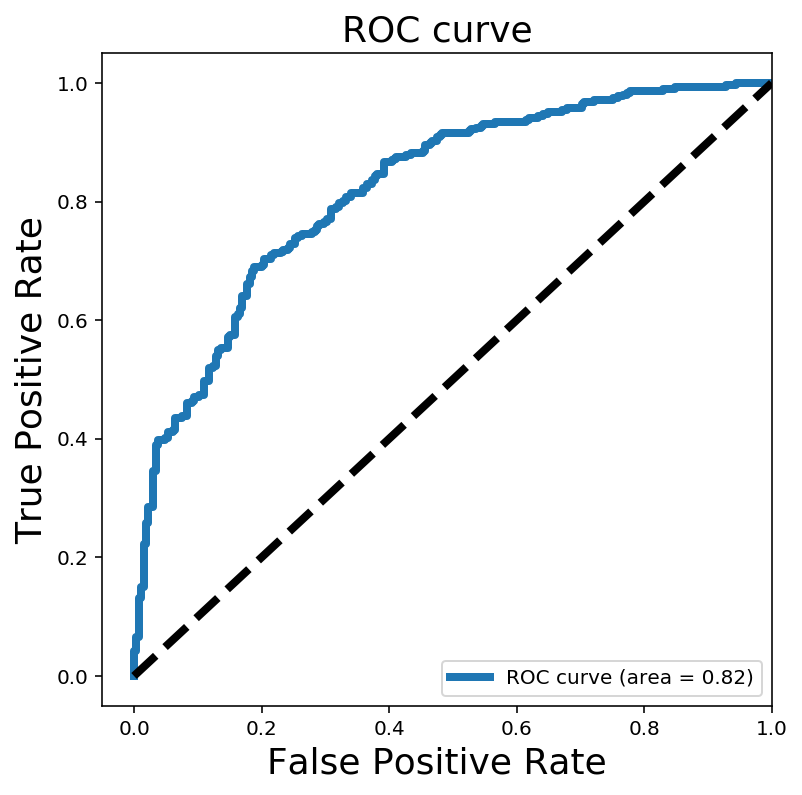

In [56]:
fpr, tpr, threshold = roc_curve(y_test, lr_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

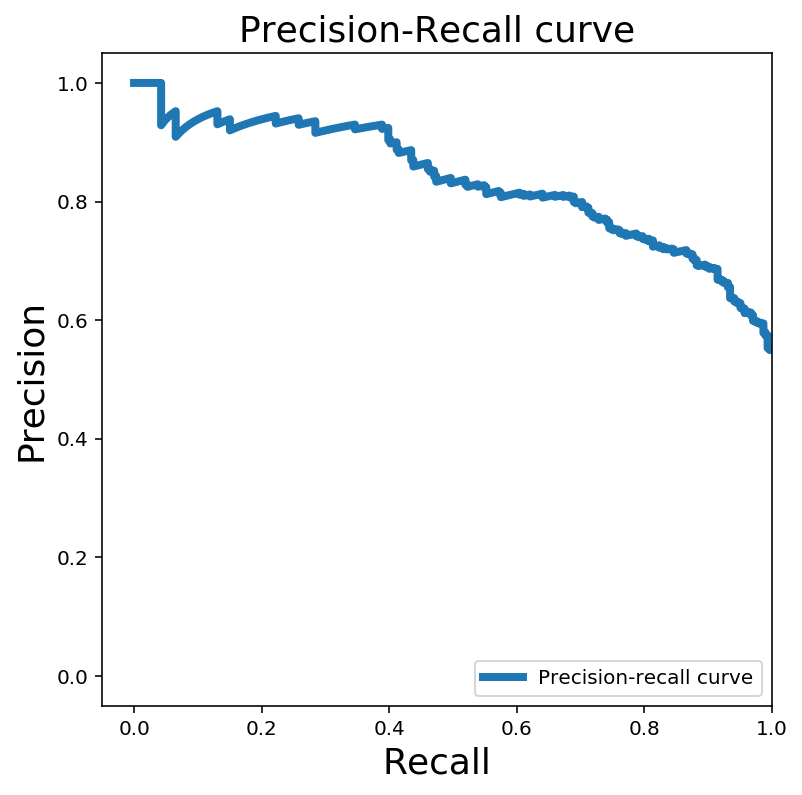

In [57]:
precision, recall, threshold = precision_recall_curve(y_test, lr_prob)

plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [60]:
#Top coeffifients, not including positive words

log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]),
                          columns = ["feature", "coeff"])

log_coeffs["abs_coeff"] = log_coeffs["coeff"].map(lambda x: abs(x))

pos_words = ["great", "excellent", "delicious", "fantastic", "perfect", "wonderful", "beautiful", "amazing", "awesome",
            "love", "tasty", "nice", "super", "best", "incredible",]

log_coeffs[["feature", "coeff"]][~log_coeffs["feature"].isin(pos_words)].sort_values("coeff", ascending=False).head(10)

,feature,coeff
1217,bread,1.500946
3318,floral,1.265917
1225,bready,1.233518
3966,helles,1.184655
2628,doughy,1.148722
3448,fresh,1.028798
7505,solid,1.027409
2125,crisp,1.004144
6852,rich,0.970606
809,balanced,0.962218


In [61]:
#Bottom coeffifients, not including negative words

neg_words = ["bad", "decent", "average", "ok", "lacking", "little", "disappointing", "didn", "doesn", "maybe"]

log_coeffs[["feature", "coeff"]][~log_coeffs["feature"].isin(neg_words)].sort_values("coeff", ascending=True).head(10)

,feature,coeff
4794,light,-1.255695
3094,faint,-1.139795
5200,metallic,-1.076524
3259,fizzy,-1.075807
8110,taste,-1.014440
3696,grainy,-0.952967
1057,bland,-0.932409
3289,flavours,-0.922863
4970,macro,-0.914958
640,aroma,-0.896891


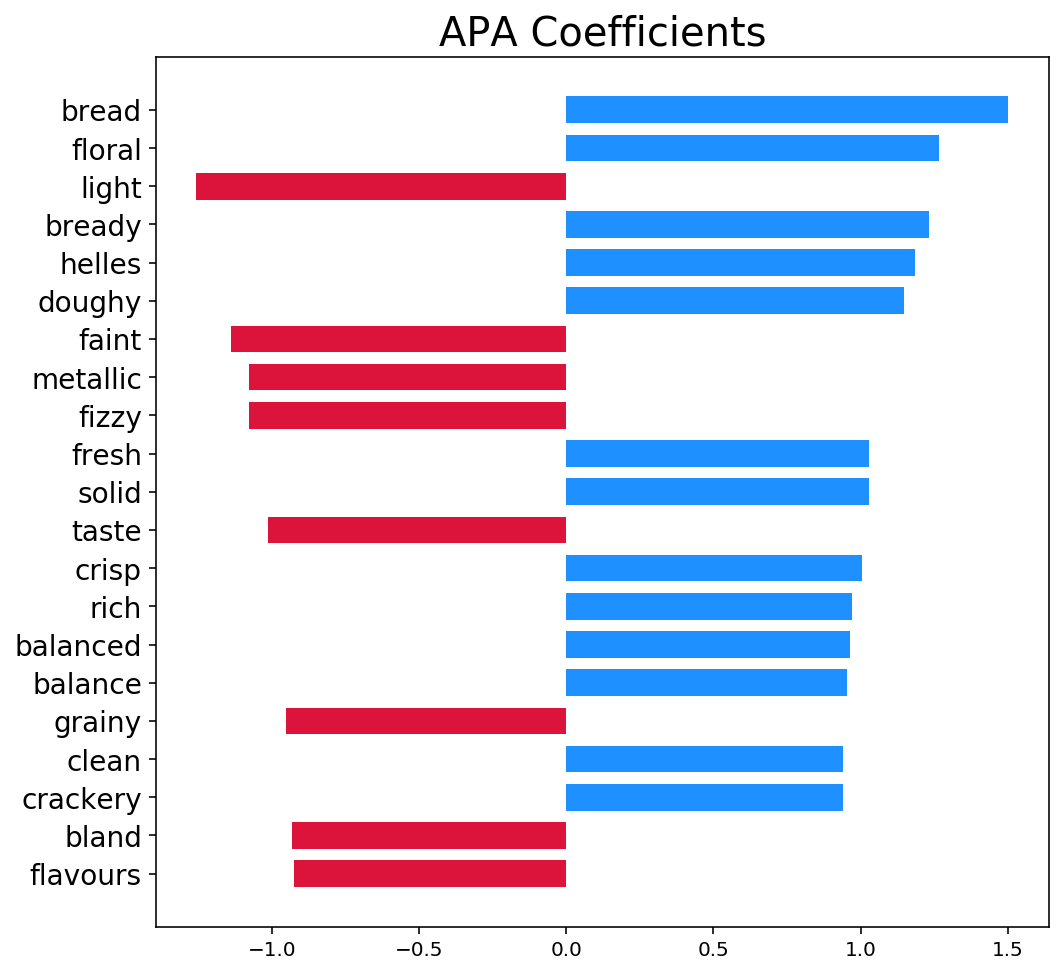

In [62]:
top_coeffs = log_coeffs[~(log_coeffs["feature"].isin(neg_words)) & 
                        ~(log_coeffs["feature"].isin(pos_words))].sort_values("abs_coeff", ascending=False)[:21]

fig = plt.figure(figsize=(8,8))
plt.barh("feature", "coeff", 
         height=.7,
         data=top_coeffs.sort_values("abs_coeff"),
         color=["#1E90FF" if x > 0 else "#DC143C" for x in top_coeffs.sort_values("abs_coeff")["coeff"]])
plt.title("APA Coefficients", fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Notes:

 - TO UPDATE

 

### Trying out the model on brewers' descriptions

In [63]:
beers = pd.read_csv("./data/helles_beers.csv")

In [64]:
beers["review"]=beers["desc"]
clean_beers = beers.dropna()

In [68]:
clean_beers.describe()

,id,rank,av_rating,n_reviews
count,62.000000,62.000000,62.000000,62.000000
mean,112073.129032,84.225806,3.771290,113.322581
std,119038.592804,4.232657,0.271779,172.454392
min,384.000000,70.000000,2.970000,4.000000
25%,18704.000000,82.000000,3.622500,14.000000
50%,59161.000000,84.500000,3.770000,43.500000
75%,183395.750000,87.000000,3.935000,122.500000
max,425373.000000,93.000000,4.420000,966.000000


In [69]:
#setting X and y, and creating split
X=clean_beers[["review"]].copy()
y=clean_beers["av_rating"].apply(lambda x: 1 if x > 3.8 else 0)

#Setting up pipeline
new_pipe = Pipeline(steps = [ ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
y_pred = new_pipe.predict(X)

In [70]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.5

In [71]:
1-y.mean()

0.5483870967741935

In [72]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.15      0.24        34
           1       0.47      0.93      0.63        28

   micro avg       0.50      0.50      0.50        62
   macro avg       0.59      0.54      0.44        62
weighted avg       0.61      0.50      0.42        62



In [73]:
conmat = confusion_matrix(y, y_pred, labels = [1,0])

pd.DataFrame(conmat,
            columns = ["p_high", "p_low"],
            index = ["high", "low"])

,p_high,p_low
high,26,2
low,29,5


In [74]:
clean_beers["rating_pred"] = y_pred

C:\Users\James\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
for i in range(0,5):
    print(clean_beers[clean_beers["rating_pred"] == 0].iloc[i,6])
    print(clean_beers[clean_beers["rating_pred"] == 0].iloc[i,10])
    print("")

3.69
Marketed as Premium Lager in the US.

4.19
A particularly mild, sparkling, long stored beer, refreshing and easily digestible at the same time. Uniquely in its taste, a benefit for each beer connoisseur.

3.97
Beer sensory characteristics: A creamy, compact head crowns the glass. Brilliant, delicately pearled with bubbles, and golden yellow; it captivates the eye of the true connoisseur. The aroma is lightly reminiscent of flowering hops. The body is pure, mild, discretely aromatic, coupled with a slight sweetness. The finish is soft, with a hint of maltiness. A lager that awakens the desire to drink it again and again. Mahrs Bräu Hell pairing recommendation: to cooked or fried fish dishes, salads, mild cheeses, stews.

3.54
Formerly Ringneck Big Woody Lager

3.64
Light, simple, and drinkable at those special gatherings you sometimes get lucky enough to happen upon - a beautiful golden goodness that's worth gathering about.



### Roc/ PR curves

In [76]:
X=clean_beers[["review"]].copy()
brew_prob = [y for x,y in new_pipe.predict_proba(X)]

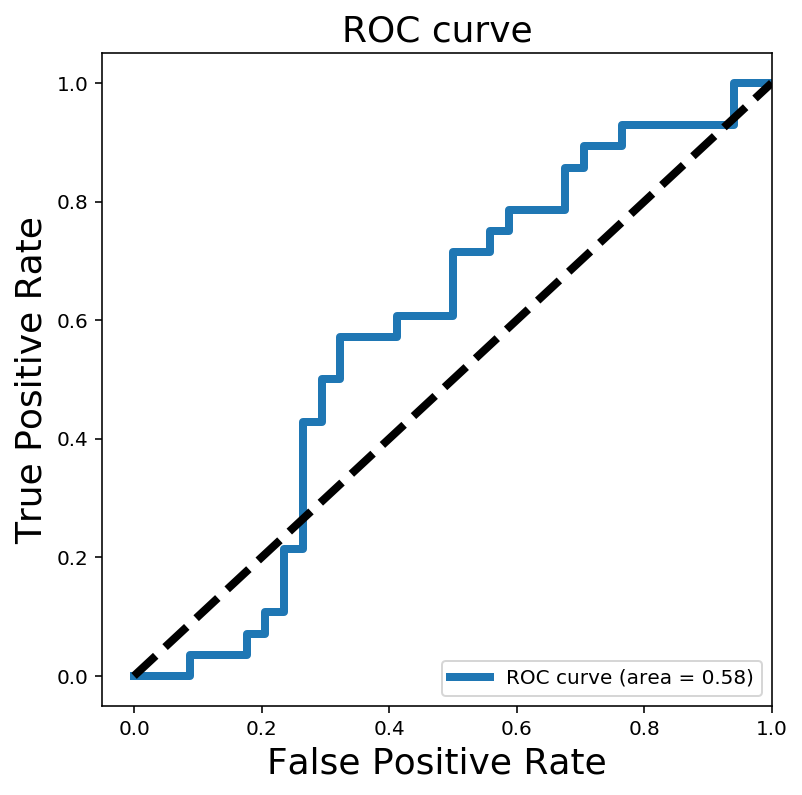

In [77]:
fpr, tpr, threshold = roc_curve(y, brew_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

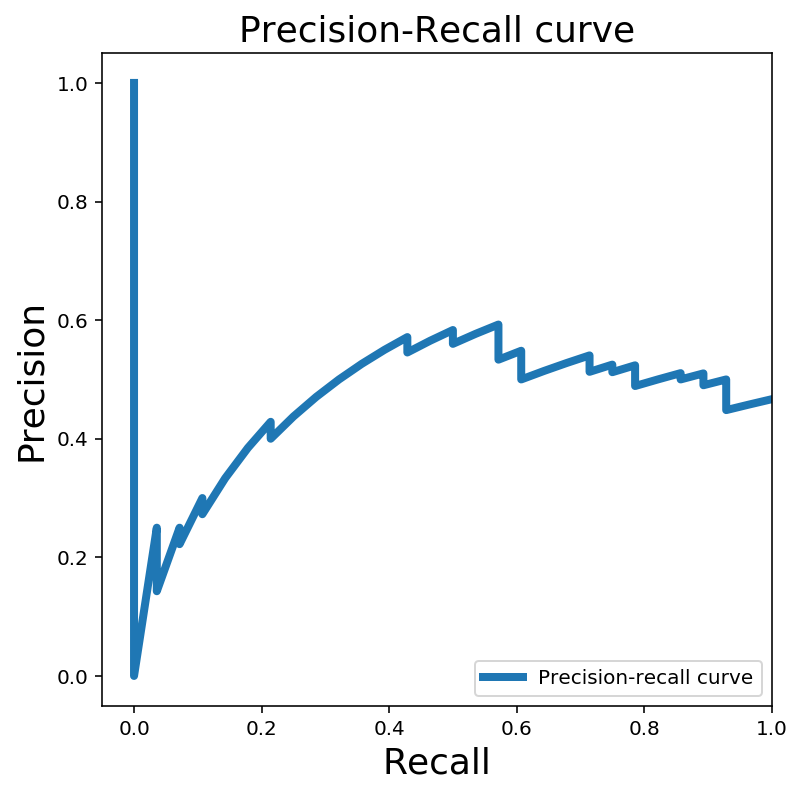

In [78]:
precision, recall, threshold = precision_recall_curve(y, brew_prob)

plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()